# Intelligent Systems 3: Probabilistic and Deep Learning

### Question 1: Regression and classification (42 marks)
**a. Train and evaluate a least squares linear regression model predicting the value of
variable D from variables A, B and C.**

In [ ]:
# This line is needed to use matplotlib in Jupyter notebook
%matplotlib inline
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale, normalize
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
np.set_printoptions(suppress=True)

# Imports the data for question 1 and 2
DATA = data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, dtype=float)

def split_data(data, train_size):
    # Shuffles the data but always in the same way to valid comparisons of models
    np.random.seed(10)
    np.random.shuffle(data)

    # separates D as the target variable
    X, y = data[:,:-1], data[:,-1]

    # Splits the data into training and test sets
    X_train, X_test = X[:-train_size], X[-train_size:]
    y_train, y_test = y[:-train_size], y[-train_size:]
    return X_train, X_test, y_train, y_test, X, y

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def least_squares_regression(data, train_size, v=0, log=True):
    """Runs linear least squares regression on the data. 
    Normalises and scales the data if specified.
    v=0 no preprocessing, v=1 normalise, v=2 scale, v=3 normalise and scale."""

    # Creates a copy of the data so the original data is not modified by the function
    data = deepcopy(data)
    
    if v == 1 or v == 3:
            data = normalize(data, axis=0) # axis=0 normalises the data by feature

    if v == 2 or v == 3:
            data = scale(data)

    if v == 4 or v == 6:
            minmax = MinMaxScaler()
            data = minmax.fit_transform(data)

    if v == 5 or v == 6:
            scaler = StandardScaler()
            data = scaler.fit_transform(data) 
    
    df = pd.DataFrame(data, columns = ['A','B','C', 'D'])
    df.plot()
    
    # Splits the data into training and test sets
    X_train, X_test, y_train, y_test, X, y = split_data(data, train_size)

    # Train model and make predictions
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    # Test of generalisation (10-fold cross-validation)
    scores = cross_val_score(regr, X, y, cv=10)

    # Prints the results
    if log:
        print("Coefficients of A, B & C:", regr.coef_)
        print('Mean squared error: %.2f'
            % mean_squared_error(y_test, y_pred))
        print('Coefficient of determination (R2): %.2f'
            % r2_score(y_test, y_pred))
        print("\nCross-Validation Mean R2 Score: " + str(scores.mean().round(2)))

    return regr, scores.mean()

print("-" * 32 + " QUESTION 1 (a) " + "-" * 32)
least_squares_regression(data=DATA, train_size=75)
print("-" * 76)

**b. Repeat the above task after carrying out in turn data normalisation, data scaling and
their combination, and evaluate the benefits of each of these 3 types of data preprocessing.**

Below show the affect of data normalisation, data scaling and the combination of the two before performing the previous linear regression.

[Normalisation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html): Scale input vectors individually to unit norm (vector length)

[Scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html#sklearn.preprocessing.scale): Standardize a dataset along any axis. Center to the mean and component wise scale to unit variance.

As shown by the R2 values for the three types of data preprocessing (and mean r2 values when running cross validation), none have had a significant impact on the efficiency of the model. This is likely due to the fact that its not neccessary to normalise or scale the data when using linear regression as the coefficients learned by the model are not affected by the scale of the input features. 

However, standardizing the data can be useful as it makes it easier to interpret the coefficients that the model has learned. For instance, if one features scale is much larger than anothers, then the coefficient for that feature may also be larger in comparison to other features with smaller scales. Standardizing prevents this as all features are on the same scale. For example, it has shown that A, B and C all affect the value for D equally. We can prove this by plotting the original data vs the scaled data which is shown below. 



In [ ]:
print("-" * 32 + " QUESTION 1 (b) " + "-" * 32)

df = pd.DataFrame(data, columns = ['A','B','C', 'D'])
df.plot()

# 1. Performs Data Normalisation - using lecture example
print("Data Normalisation:")
least_squares_regression(data=DATA, train_size=75, v=1)
print("-" * 76)

# 2. Performs Data Scaling - using lecture example
print("Data scaling")
least_squares_regression(data=DATA, train_size=75, v=2)
print("-" * 76)

# 3. Performs Data Normalisation and Data Scaling - using lecture examples
print("Norm then Scale")
least_squares_regression(data=DATA, train_size=75, v=3)
print("-" * 76)

# 4. Performs Data Normalisation - using min max
print("Norm - min max")
least_squares_regression(data=DATA, train_size=75, v=4)
print("-" * 76)

# 3. Performs Scaling - using standard scaler
print("Scale - standard scaler")
least_squares_regression(data=DATA, train_size=75, v=5)
print("-" * 76)

# 3. Performs Data Normalisation and Data Scaling - using MinMaxScaler and StandardScaler
print("Scale - min max then scaler")
least_squares_regression(data=DATA, train_size=75, v=6)
print("-" * 76)

**c. Try to outperform the best result of the previous step by using regularisation (e.g. L1,
L2 or Elastic Net). Show how any parameter values are tuned and evaluate the benefits of
regularisation.**

The use of regularisation has been implemented by using RidgeCV regression. The data was first pre-processed by standardising it - removing the mean and scaling to unit variance. This is important as if features have different scales, then the penalty term will have a different effect on the coefficients of the features, depending on their scale. This can mean that the model may give more weight to features with larger scales, potentially ignoring smaller ones.

The alpha value was determined by using cross-validation to determine the most successful value from the following list `[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]`. The value chosen was 0.1.

In comparison to the previous regressions, this model has not performed any better, producing an identical R2 (and cross valided mean R2) value. As shown previously, we can see that the 3 features (A, B & C) are direct translations of each other. Its generally not a good idea to use highly correlated features in any type of regularized linear regression. The penalty term is not likely to be able to effectively determine any unimportant features as once scaled these features are identical (shown by the coefficients of A, B & C being identical). This therefore means that the addition of the penalty term had no additional effect.


In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def regularisation(data, train_size, log=True):
    # Creates a copy of the data so the original data is not modified by the function
    data = deepcopy(data)

    # Splits the data into training and test sets
    X_train, X_test, y_train, y_test, X, y = split_data(data, train_size)

    pipe = Pipeline([('Scaler', StandardScaler()), ('RidgeCV', RidgeCV(alphas=np.logspace(-6, 6, 13)))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Test of generalisation (10-fold cross-validation)
    scores = cross_val_score(pipe, X, y, cv=10)

    if log:
        print('Testing complexity parameter values (i.e.alphas): ', np.logspace(-6, 6, 13))
        print('Cross-validation got this value for the complexity parameter: ', pipe.named_steps['RidgeCV'].alpha_)
        for i, name in enumerate(["A", "B", "C"]):
            print('Coefficient for {0} is {1}'.format(name,pipe.named_steps['RidgeCV'].coef_[i]))
        print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
        print('Coefficient of determination (R2): %.2f' % r2_score(y_test, y_pred))
        print("\nCross-Validation Mean R2 Score: " + str(scores.mean().round(2)))

    return pipe, scores.mean()

print("-" * 32 + " QUESTION 1 (c) " + "-" * 32)
regularisation(data=DATA, train_size=75)
print("-" * 76)

**4. Add a set of suitable basis functions to the original data and train a linear regression
with an appropriate type of regularisation to find out which of the new basis functions bring
benefits. Explain briefly (in no more than 4 sentences) your reasoning.**

As when scaled they are all identical, therefore A^2(B) = A^3

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(data, train_size, log=True):
    data = deepcopy(data)
    
    # splits the data into training and test sets
    X_train, X_test, y_train, y_test, X, y = split_data(data, train_size)

    pipe = Pipeline([('Scaler', StandardScaler()), ("BasisFunctions", PolynomialFeatures(3)), ("RidgeCV", RidgeCV(alphas=np.logspace(-6, 6, 13)))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Test of generalisation (10-fold cross-validation)
    scores = cross_val_score(pipe, X, y, cv=10)

    if log:
        print('Cross-validation got this value for the complexity parameter: ', pipe.named_steps['RidgeCV'].alpha_)
        for i, name in enumerate(["1 (bias)", "A", "B", "C", "A^2", "AB", "AC", "B^2", "BC", "C^2", "A^3", "(A^2)B", "(A^2)C", "A(B^2)", "ABC", "A(C^2)", "B^3", "(B^2)C", "B(C^2)", "C^3"]):
            print('Parameter for {0} is {1}'.format(name,pipe.named_steps['RidgeCV'].coef_[i]))
        print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
        print('Coefficient of determination (R2): %.2f' % r2_score(y_test, y_pred))
        print("\nCross-Validation Mean R2 Score: " + str(scores.mean().round(2)))

    return pipe, scores.mean()

print("-" * 32 + " QUESTION 1 (d) " + "-" * 32)
polynomial_regression(DATA, 75)
print("-" * 76)


**5. Implement an appropriate automated procedure that will train all of the above models
and select the model expected to perform best on unseen data with the same distribution as your
training data. You need to include a code tile at the end of this section of your Jupyter notebook
that attempts to test your final choice of model on a data set stored in a file unseendata.csv
and compute $R^2$ for it. The file will have exactly the same format as file data.csv, including
the header, but possibly a different overall number of rows. This means you can use a renamed
copy of data.csv to debug that part of your code, and to produce the corresponding content
for your PDF file (in order to demonstrate that this part of the code is in working order).**


In [ ]:
def choose_best_model(data, train_size):
    """Returns the model with the highest averaged cross-validation r2 score."""
    i, name, best_model, best_model_CV_mean = 1, None, None, None

    for v in range(0, 3):
        regr, cv_mean = least_squares_regression(data, train_size, v, log=False)
        if v == 0:
                mod_name = "Linear Regression"
        elif v == 1:
            mod_name = "Linear Regression with Normalisation"
        elif v == 2:
            mod_name = "Linear Regression with Standardisation"
        elif v == 3: 
            mod_name = "Linear regression with Normalisation and Standardisation"
        if best_model_CV_mean is None or cv_mean > best_model_CV_mean:
            name, best_model, best_model_CV_mean = mod_name, regr, cv_mean
        print(f"{i}. {mod_name} has a mean r2 score of {cv_mean.round(2)}")
        i += 1
            
    regr, cv_mean = regularisation(data, train_size, log=False)
    mod_name = "Regularisation"
    if cv_mean > best_model_CV_mean:
        best_model, best_model_CV_mean = regr, cv_mean
        name = mod_name
    print(f"{4}. {mod_name} has a mean r2 score of {cv_mean.round(2)}")
    
    regr, cv_mean = polynomial_regression(data, train_size, log=False)
    mod_name = "Linear regression with polynomial basis functions"
    if cv_mean > best_model_CV_mean:
        best_model, best_model_CV_mean = regr, cv_mean
        name = mod_name
    print(f"{5}. {mod_name} has a mean r2 score of {cv_mean.round(2)}")
    
    print("\nThe best model to perform on unseen data is " + name + " as it has the highest mean r2 score of " + str(best_model_CV_mean.round(2)) + " after running 10-fold cross validation\n")
    
    return best_model

def test_unseen(best_model):
    """Runs the best model on the unseen data. Prints the mean squared error and R2 score."""
    unseen_data = np.genfromtxt('unseendata.csv', delimiter=',', skip_header=1, dtype=float)
    X, y = unseen_data[:,:-1], unseen_data[:,-1]
    y_pred = best_model.predict(X)
    print("Running on unseendata.csv...")
    print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
    print('Coefficient of determination (R2): %.2f' % r2_score(y, y_pred))

print("-" * 32 + " QUESTION 1 (e) " + "-" * 32)
best_model = choose_best_model(DATA, 75)
test_unseen(best_model)
print("-" * 76)

6. Starting with the data in data.csv, find the median value of variable D. Replace all
values up to and including the median value with 0, and all values greater than that with 1. Treat
the resulting values of D as class labels to train and evaluate a classifier based on logistic
regression that takes variables A, B and C as input.

In [ ]:
def logistic_regression(data, train_size):
    # Replaces the last column with 1 if the value is greater than the median, 0 otherwise.
    median = np.median(data[:, 3])
    data[:, 3] = np.where(data[:, 3] > median, 1, 0)

    # Splits the data into training and test sets
    X_train, X_test, y_train, y_test, X, y = split_data(data, train_size)

    # Runs logistic regression
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)

    predictions = logisticRegr.predict(X_test)
    probability_predictions = logisticRegr.predict_proba(X_test)

    # Shows first 5 predictions
    print("First 5 example predictions:")
    for i in range(5):
        print("Predicted class:", predictions[i], "(Probability:" + str(probability_predictions[i][int(predictions[i])].round(4)) + ")")

     # Use score method to get out of sample accuracy of the model (2 decimal places)

    score = logisticRegr.score(X_test, y_test)
    print("\nOut of sample accuracy = " + str(score.round(2)*100) + "%")

    # Test of generalisation (10-fold cross-validation)
    scores = cross_val_score(logisticRegr, X, y, cv=10)

    print("\nCross-Validation Mean Out of Sample Accuracy: " + str(scores.mean().round(2)*100) + "%")

print("-" * 32 + " QUESTION f (d) " + "-" * 32)
logistic_regression(DATA, 75)
print("-" * 76)

# Question 2: Principal Component Analysis (8 marks)
**Starting with the same data.csv file from Q1, extend the table with 6 additional columns
consisting of the product of each pair of the original 4 variables A, B, C and D.
Apply principal component analysis (PCA) with a number of principal components (PCs) equal to
the number of original variables, i.e. p = 4. Label the resulting principal components in
decreasing order of variance as PC1. . .PC4 and list the linear equations showing how each of
them is calculated from the 10 input variables. Describe which variables affect most strongly
each of the 4 principal components, highlighting any notable findings and providing plausible
explanations for them.**

In [ ]:
from sklearn.decomposition import PCA
from itertools import combinations

data = np.loadtxt('data.csv',delimiter=',',skiprows=1)
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

# extend the table with 6 additional column consisting of the product of each pair of the original 4 variables A, B, C and D
for i, j in combinations(range(4), 2):
    scaled_data = np.hstack((scaled_data, np.atleast_2d(np.multiply(scaled_data[:, i], scaled_data[:, j])).T))


pca = PCA(n_components=4)
pca.fit(scaled_data)
newData = pca.fit_transform(scaled_data)

NewTotVar = 0
for i, dim in enumerate(('PC1','PC2','PC3','PC4')):
  Var2 = np.var(newData[:,i])
  NewTotVar += Var2

  print('Sample variance for the {0} dimension'.format(dim))
  
  print('var = {0}\n\n'.format(Var2))

# TODO: list linear equations showing how each is calculated


# Question 3

classification, multiclass -> unconstrainted  use softmax to convert to probability distribution
compare estimated probability dis with correct one by using cross entropy loss
black + white image means 2d tensor

number of items = batch size first dimension of tensor
channels or features are special dimension

https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

https://medium.com/analytics-vidhya/augment-your-data-easily-with-pytorch-313f5808fc8b

https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from torch.utils.data.sampler import WeightedRandomSampler

Total dataset : 
Class 0 has 6000 samples - 35.65%
Class 1 has 181 samples - 1.08%
Class 2 has 606 samples - 3.60%
Class 3 has 3685 samples - 21.90%
Class 4 has 6356 samples - 37.77%


Train set: 
Class 0 has 4800 samples - 35.66%
Class 1 has 145 samples - 1.08%
Class 2 has 485 samples - 3.60%
Class 3 has 2948 samples - 21.90%
Class 4 has 5084 samples - 37.77%


Test set: 
Class 0 has 1200 samples - 35.65%
Class 1 has 36 samples - 1.07%
Class 2 has 121 samples - 3.59%
Class 3 has 737 samples - 21.90%
Class 4 has 1272 samples - 37.79%




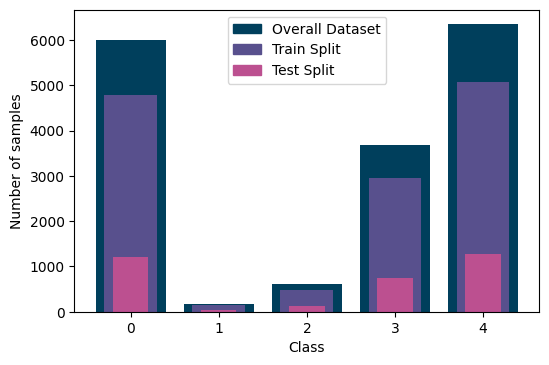

In [142]:
def print_split_stats(counts):
    total = sum(counts.values())
    for k, v in sorted(counts.items()):
        print(f"Class {k} has {v} samples - {v/total*100:.2f}%")
    print("\n")

figure(figsize=(6, 4), dpi=100)
plt.xlabel("Class")
plt.ylabel("Number of samples")

data = datasets.ImageFolder(root='images', transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()]))
total_num_classes = Counter(data.targets)
print("Total dataset : ")
print_split_stats(total_num_classes)
plt.bar(total_num_classes.keys(), total_num_classes.values(), color='#003f5c')

indices = list(range(len(data)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=data.targets)

train_dataset = Subset(data, train_indices)
num_class_train = Counter(data.targets[i] for i in train_indices)
print("Train set: ")
print_split_stats(num_class_train)
plt.bar(num_class_train.keys(), num_class_train.values(), width=0.6, color='#58508d')

test_dataset = Subset(data, test_indices)
num_class_test = Counter(data.targets[i] for i in test_indices)
print("Test set: ")
print_split_stats(num_class_test)
plt.bar(num_class_test.keys(), num_class_test.values(), width=0.4, color='#bc5090')

overall_patch = mpatches.Patch(color='#003f5c', label='Overall Dataset')
train_patch = mpatches.Patch(color='#58508d', label='Train Split')
test_patch = mpatches.Patch(color='#bc5090', label='Test Split')

plt.legend(handles=[overall_patch, train_patch, test_patch]);

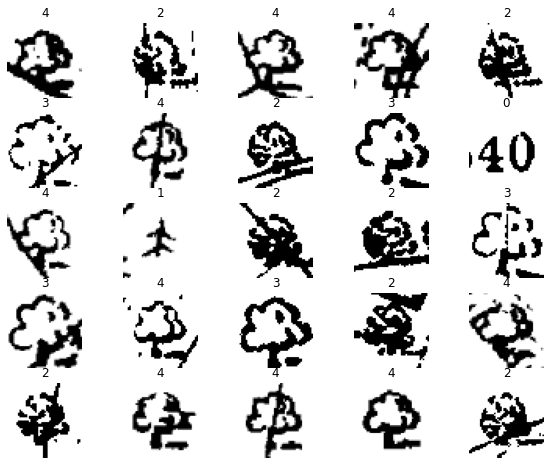

In [144]:
y_train = [data.targets[i] for i in train_indices]
class_sample_count = np.array([v for _, v in sorted(num_class_train.items())])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

images, labels = next(iter(train_dataloader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels[i].item())
    plt.axis("off")
    plt.imshow(images[i,:].squeeze(), cmap="gray")
plt.show()


https://www.maskaravivek.com/post/pytorch-weighted-random-sampler/